# Run this to get going

In [1]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import NMF

from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import patsy

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline
plt.style.use('ggplot')

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)

######################################################################################


# We'll use this to adjust for inflation to 2017 USD
filepath = "../inflation.csv"
inflation = pd.read_csv(filepath)

inflation['DATE'] = pd.to_datetime(inflation.DATE)

funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']


# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)
df_objects['sector'] = df_objects['category_code']
del df_objects['category_code']

# To be used for timing
df_funding_timing = df_funding.merge(df_objects[['id', 'sector']], left_on='funded_object_id', right_on='id')

# Let's scale raised amount for later use.
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')

# DTYPE FOR INVESTORS IS A TUPLE
d1 = df_funding.groupby(['funded_object_id', 'funding_round_code_clean']).agg(
    {'investor_object_id': lambda x: tuple(x), 'raised_amount_usd': 'sum', 'funded_at': 'max'}
).unstack().sort_index(1, 1)

d1.columns = d1.columns.to_series().map('{0[0]}_{0[1]}'.format)

# I don't like structure that gave me. Let's use this order and push the company id out of the index.
d1 = d1[['raised_amount_usd_angel', 'raised_amount_usd_seed', 'raised_amount_usd_a', 'raised_amount_usd_b', 
         'raised_amount_usd_c', 'raised_amount_usd_series_d_above', 'raised_amount_usd_secondary_market', 
         'raised_amount_usd_series_unknown', 'raised_amount_usd_other',
         'investor_object_id_angel', 'investor_object_id_seed', 'investor_object_id_a', 
         'investor_object_id_b', 'investor_object_id_c', 'investor_object_id_series_d_above', 
         'investor_object_id_secondary_market', 'investor_object_id_series_unknown', 'investor_object_id_other',
         'funded_at_angel', 'funded_at_seed', 'funded_at_a', 'funded_at_b', 'funded_at_c', 'funded_at_series_d_above',
         'funded_at_secondary_market', 'funded_at_series_unknown', 'funded_at_other']]
d1 = d1.reset_index()

# ALL OF THE MERGES!!! Now we can put that df_objects to use
df = pd.merge(left=df_objects, right=d1, left_on='id', right_on='funded_object_id')
del df['funded_object_id']

# Remove duplicates and useless company names
df = df[df['name'] != 'eHealth Technologies']
df = df[df['name'] != 'L']
df = df[df['name'] != '']

# Also make some things a datetime
df['founded_at'] = pd.to_datetime(pd.Series(df['founded_at']))
df['closed_at'] = pd.to_datetime(pd.Series(df['closed_at']))

# Sprinkle in some feature engineering: Time between investments
df['angel_to_a'] = df['funded_at_a'] - df['funded_at_angel']
df['seed_to_a'] = df['funded_at_a'] - df['funded_at_seed']
df['a_to_b'] = df['funded_at_b'] - df['funded_at_a']
df['b_to_c'] = df['funded_at_c'] - df['funded_at_b']
df['c_to_d'] = df['funded_at_series_d_above'] - df['funded_at_c']

# Reset the index of the Maester Dataframe
df = df.reset_index(drop=True)

In [37]:
fixing_nans = ['id']
for i in df.columns:
    if 'raised_amount_usd_' in i:
        fixing_nans.append(i)
    else:
        pass

df_ = df[fixing_nans].apply(lambda x: x.fillna(value=0))

In [40]:
data = df.merge(df_, how='inner', right_on='id', left_on='id')

In [7]:
df_objects[df_objects['id'] == 'c:242735']

,id,normalized_name,name,status,founded_at,closed_at,funding_rounds,funding_total_usd,sector
97784,c:242735,sigmacare,sigmacare,operating,2005-01-01,None,1.0,2.600000e+09,health


In [5]:
df_funding.iloc[69712]

funding_round_id                          42703
investor_object_id                       f:4116
funded_object_id                       c:225650
raised_amount_usd                      1.82e+08
funded_at                   2013-07-01 00:00:00
funding_round_code_clean       secondary_market
Name: 69712, dtype: object

In [2]:
df_funding[(df_funding['funded_at'] > '2013-06-29') & (df_funding['funded_at'] < '2013-07-05')].raised_amount_usd.sort_values(ascending=False)

71032    2.600000e+09
69712    1.820000e+08
69711    1.820000e+08
71023    1.000000e+08
70017    1.000000e+08
68881    1.000000e+08
69736    6.600000e+07
69283    5.800000e+07
69168    5.500000e+07
69169    5.500000e+07
69307    5.000000e+07
69306    5.000000e+07
69305    5.000000e+07
69304    5.000000e+07
69735    4.500000e+07
70094    4.200000e+07
69156    4.000000e+07
70728    4.000000e+07
70632    3.580000e+07
68844    3.360000e+07
71001    3.000000e+07
69183    3.000000e+07
70398    3.000000e+07
68867    2.650000e+07
68868    2.650000e+07
70103    2.500000e+07
70828    2.500000e+07
68970    1.900000e+07
73559    1.800000e+07
73558    1.800000e+07
             ...     
72834             NaN
73633             NaN
73634             NaN
74070             NaN
74071             NaN
74152             NaN
74153             NaN
74879             NaN
74880             NaN
74881             NaN
75122             NaN
75123             NaN
75826             NaN
75945             NaN
75946     

## Given the data, 2005 to 2013  has a substantial amount of information

In [43]:
high_level = df_funding_timing.groupby(['funded_at']).agg({'raised_amount_usd': 'sum', 'funding_round_id': 'count'})
high_level = high_level.iloc[-108:].reset_index()
high_level.rename(columns={'funding_round_id':'number_of_investments'}, inplace=True)

In [65]:
adjusted_high_level = high_level.merge(inflation, left_on='funded_at', right_on='DATE')
del adjusted_high_level['DATE']

adjusted_high_level['current_USD'] = adjusted_high_level.raised_amount_usd * (100 / adjusted_high_level.CPIAUCSL_NBD20170101)
adjusted_high_level['USD_diff'] = adjusted_high_level.current_USD.diff()
adjusted_high_level['num_diff'] = adjusted_high_level.number_of_investments.diff()
adjusted_high_level['rolling_annual_USD'] = adjusted_high_level.current_USD.rolling(window=12).mean()

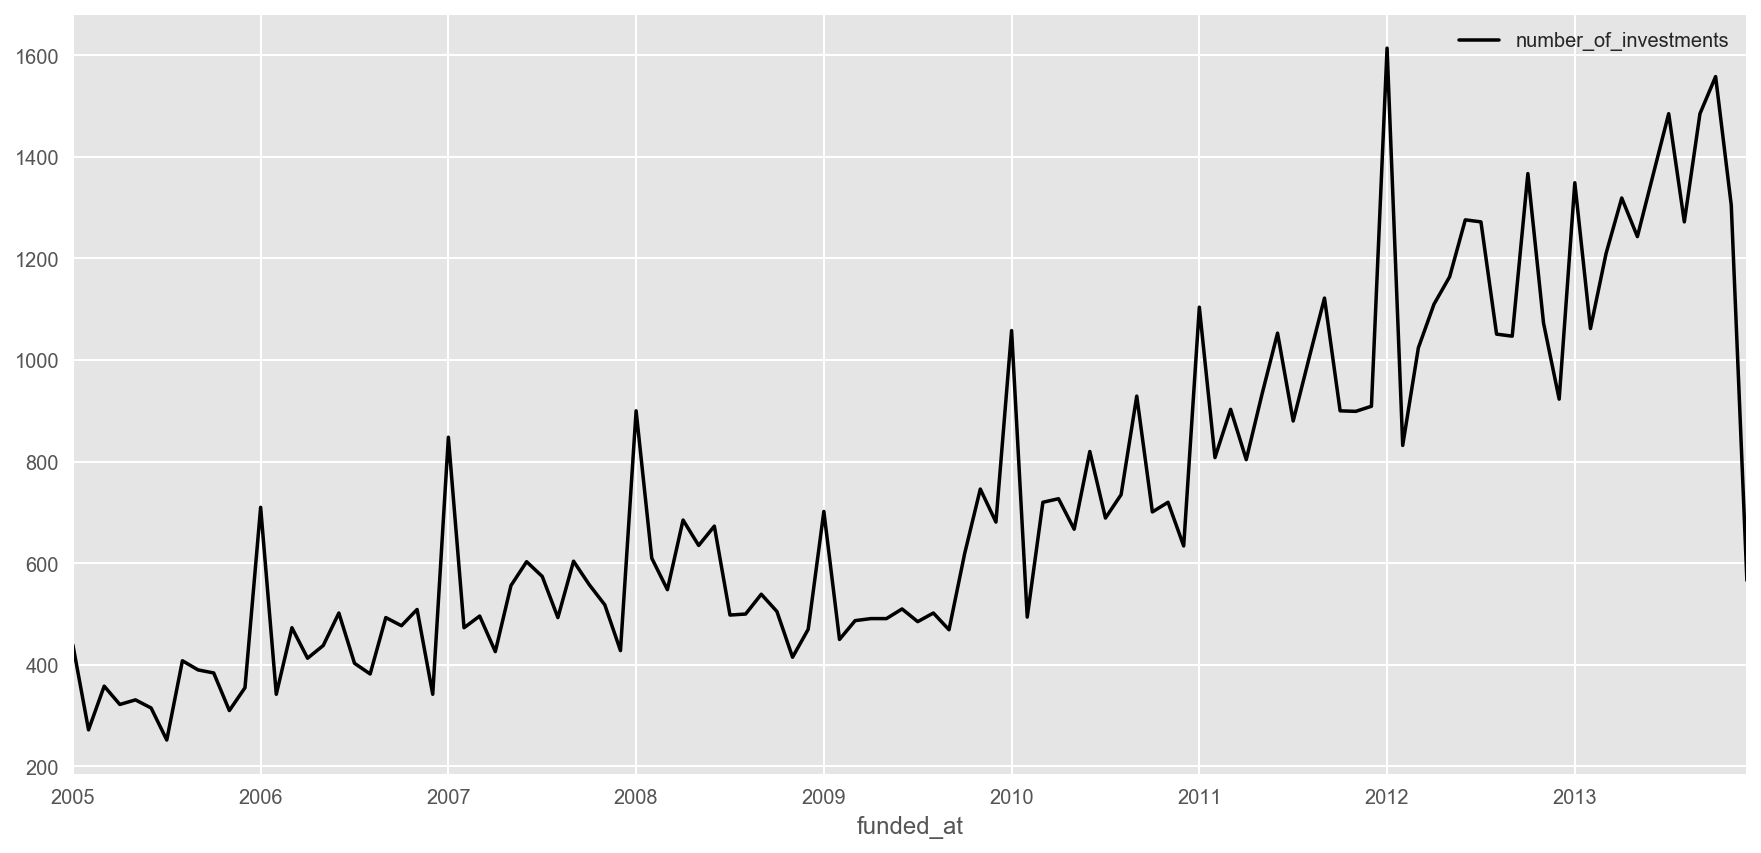

In [24]:
adjusted_high_level.plot(x='funded_at', y='number_of_investments', figsize=(15,7), color='black')

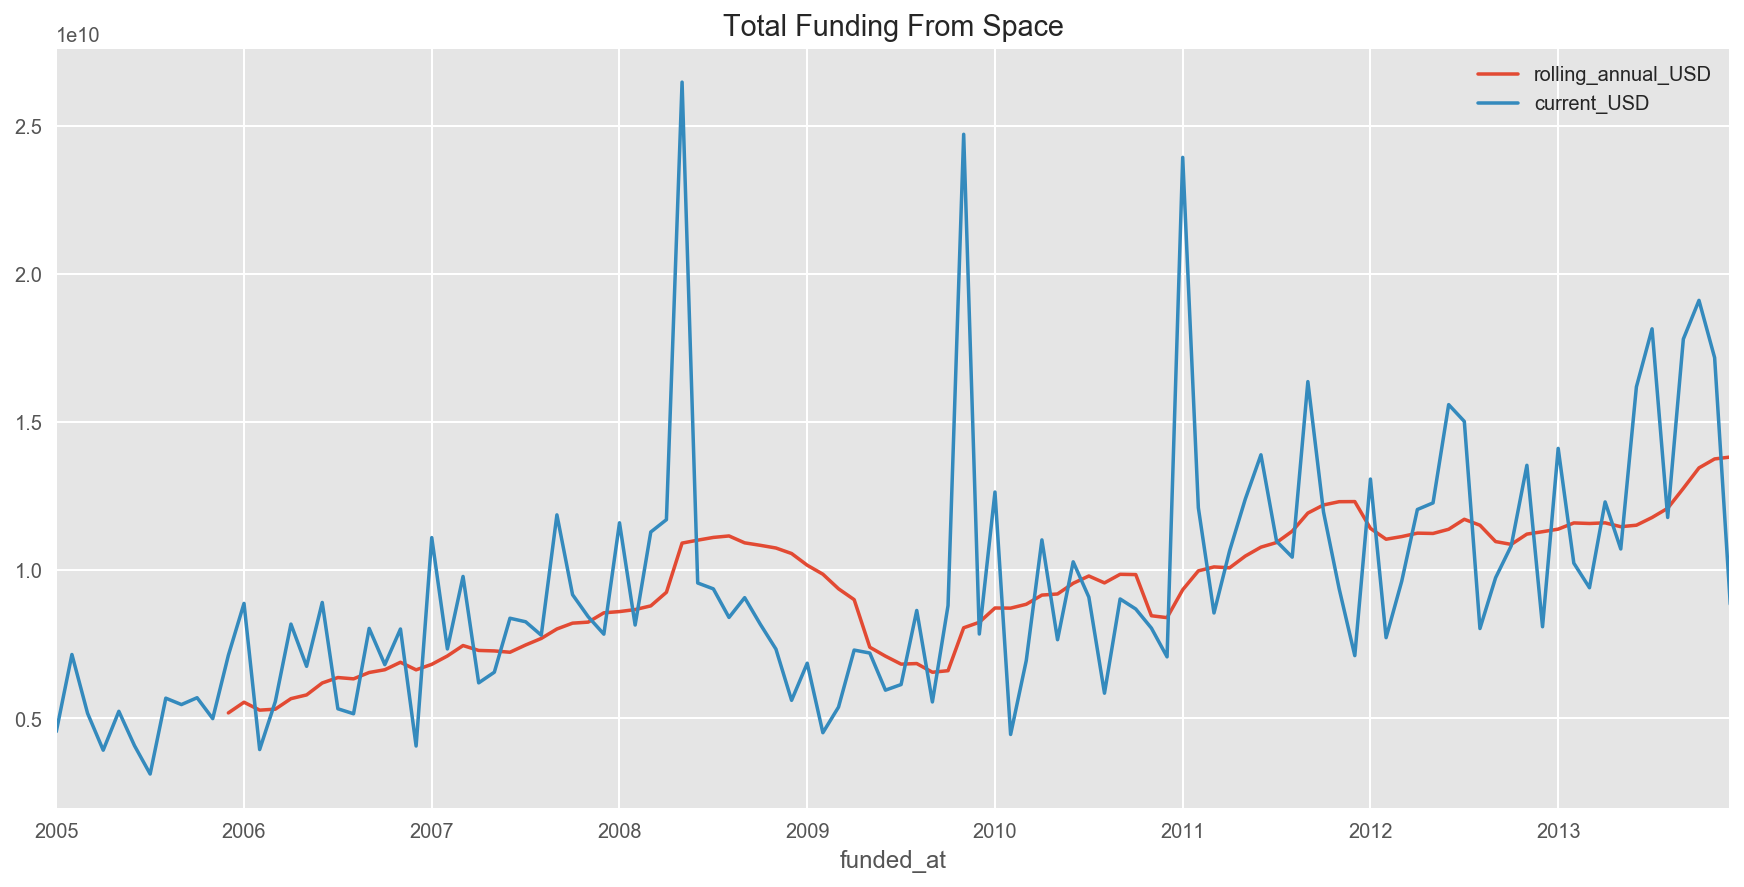

In [55]:
adjusted_high_level.plot(x='funded_at', y=['rolling_annual_USD', 'current_USD'], figsize=(15,7), title='Total Funding From Space')

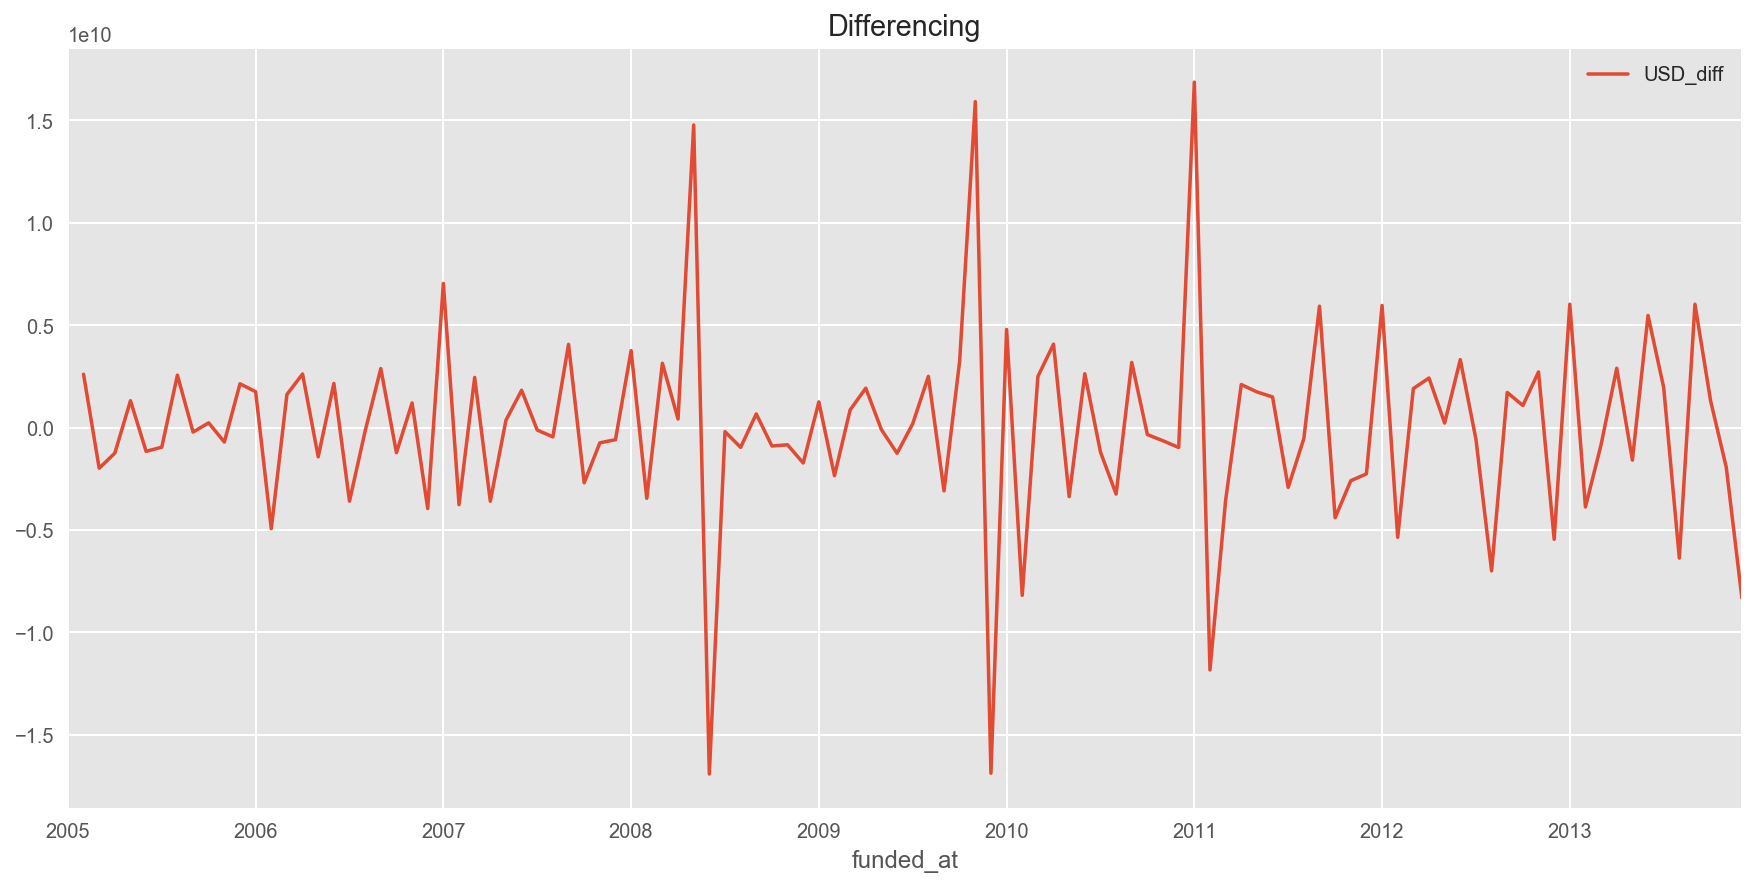

In [69]:
adjusted_high_level.plot(x='funded_at', y=['USD_diff'], figsize=(15,7), title='Differencing')

In [57]:
high_level['rolling_annual_num_investments'] = high_level.number_of_investments.rolling(window=12).mean()
high_level['rolling_annual_mean'] = high_level.raised_amount_usd.rolling(window=12).mean()
high_level['rolling_annual_stdev'] = high_level.raised_amount_usd.rolling(window=12).std()
high_level['rolling_quarter_mean'] = high_level.raised_amount_usd.rolling(window=3).mean()
high_level['rolling_quarter_stdev'] = high_level.raised_amount_usd.rolling(window=3).std()
high_level['expanding_mean'] = high_level.raised_amount_usd.expanding().mean()

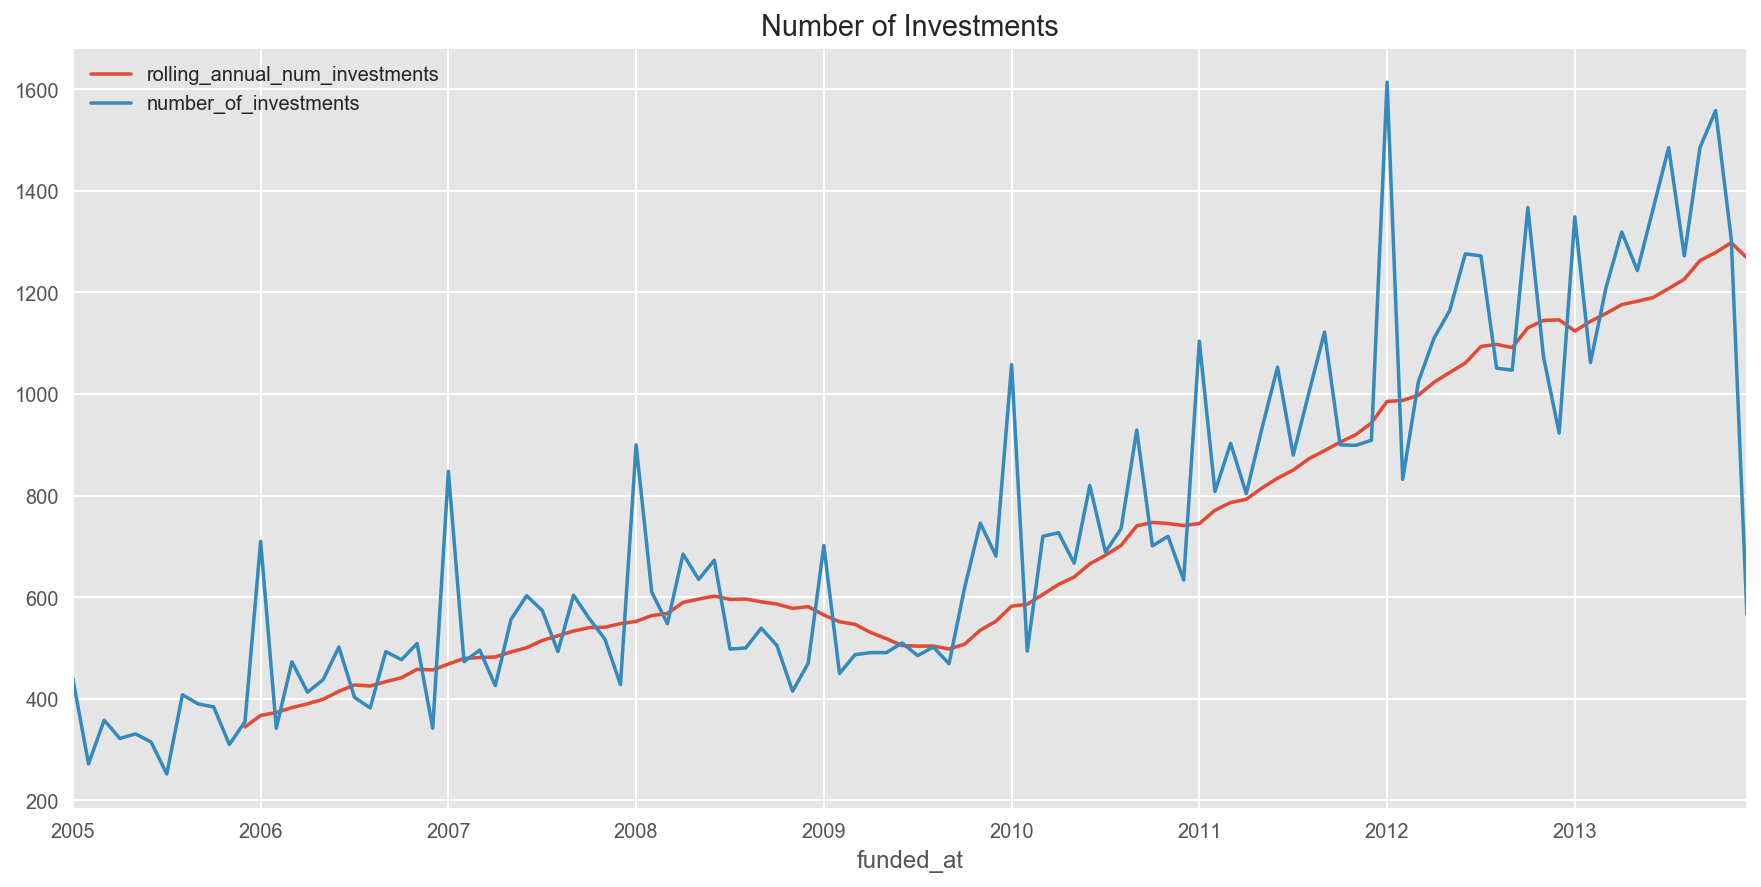

In [58]:
high_level.plot(x='funded_at', y=['rolling_annual_num_investments', 'number_of_investments'], figsize=(15,7), title='Number of Investments')

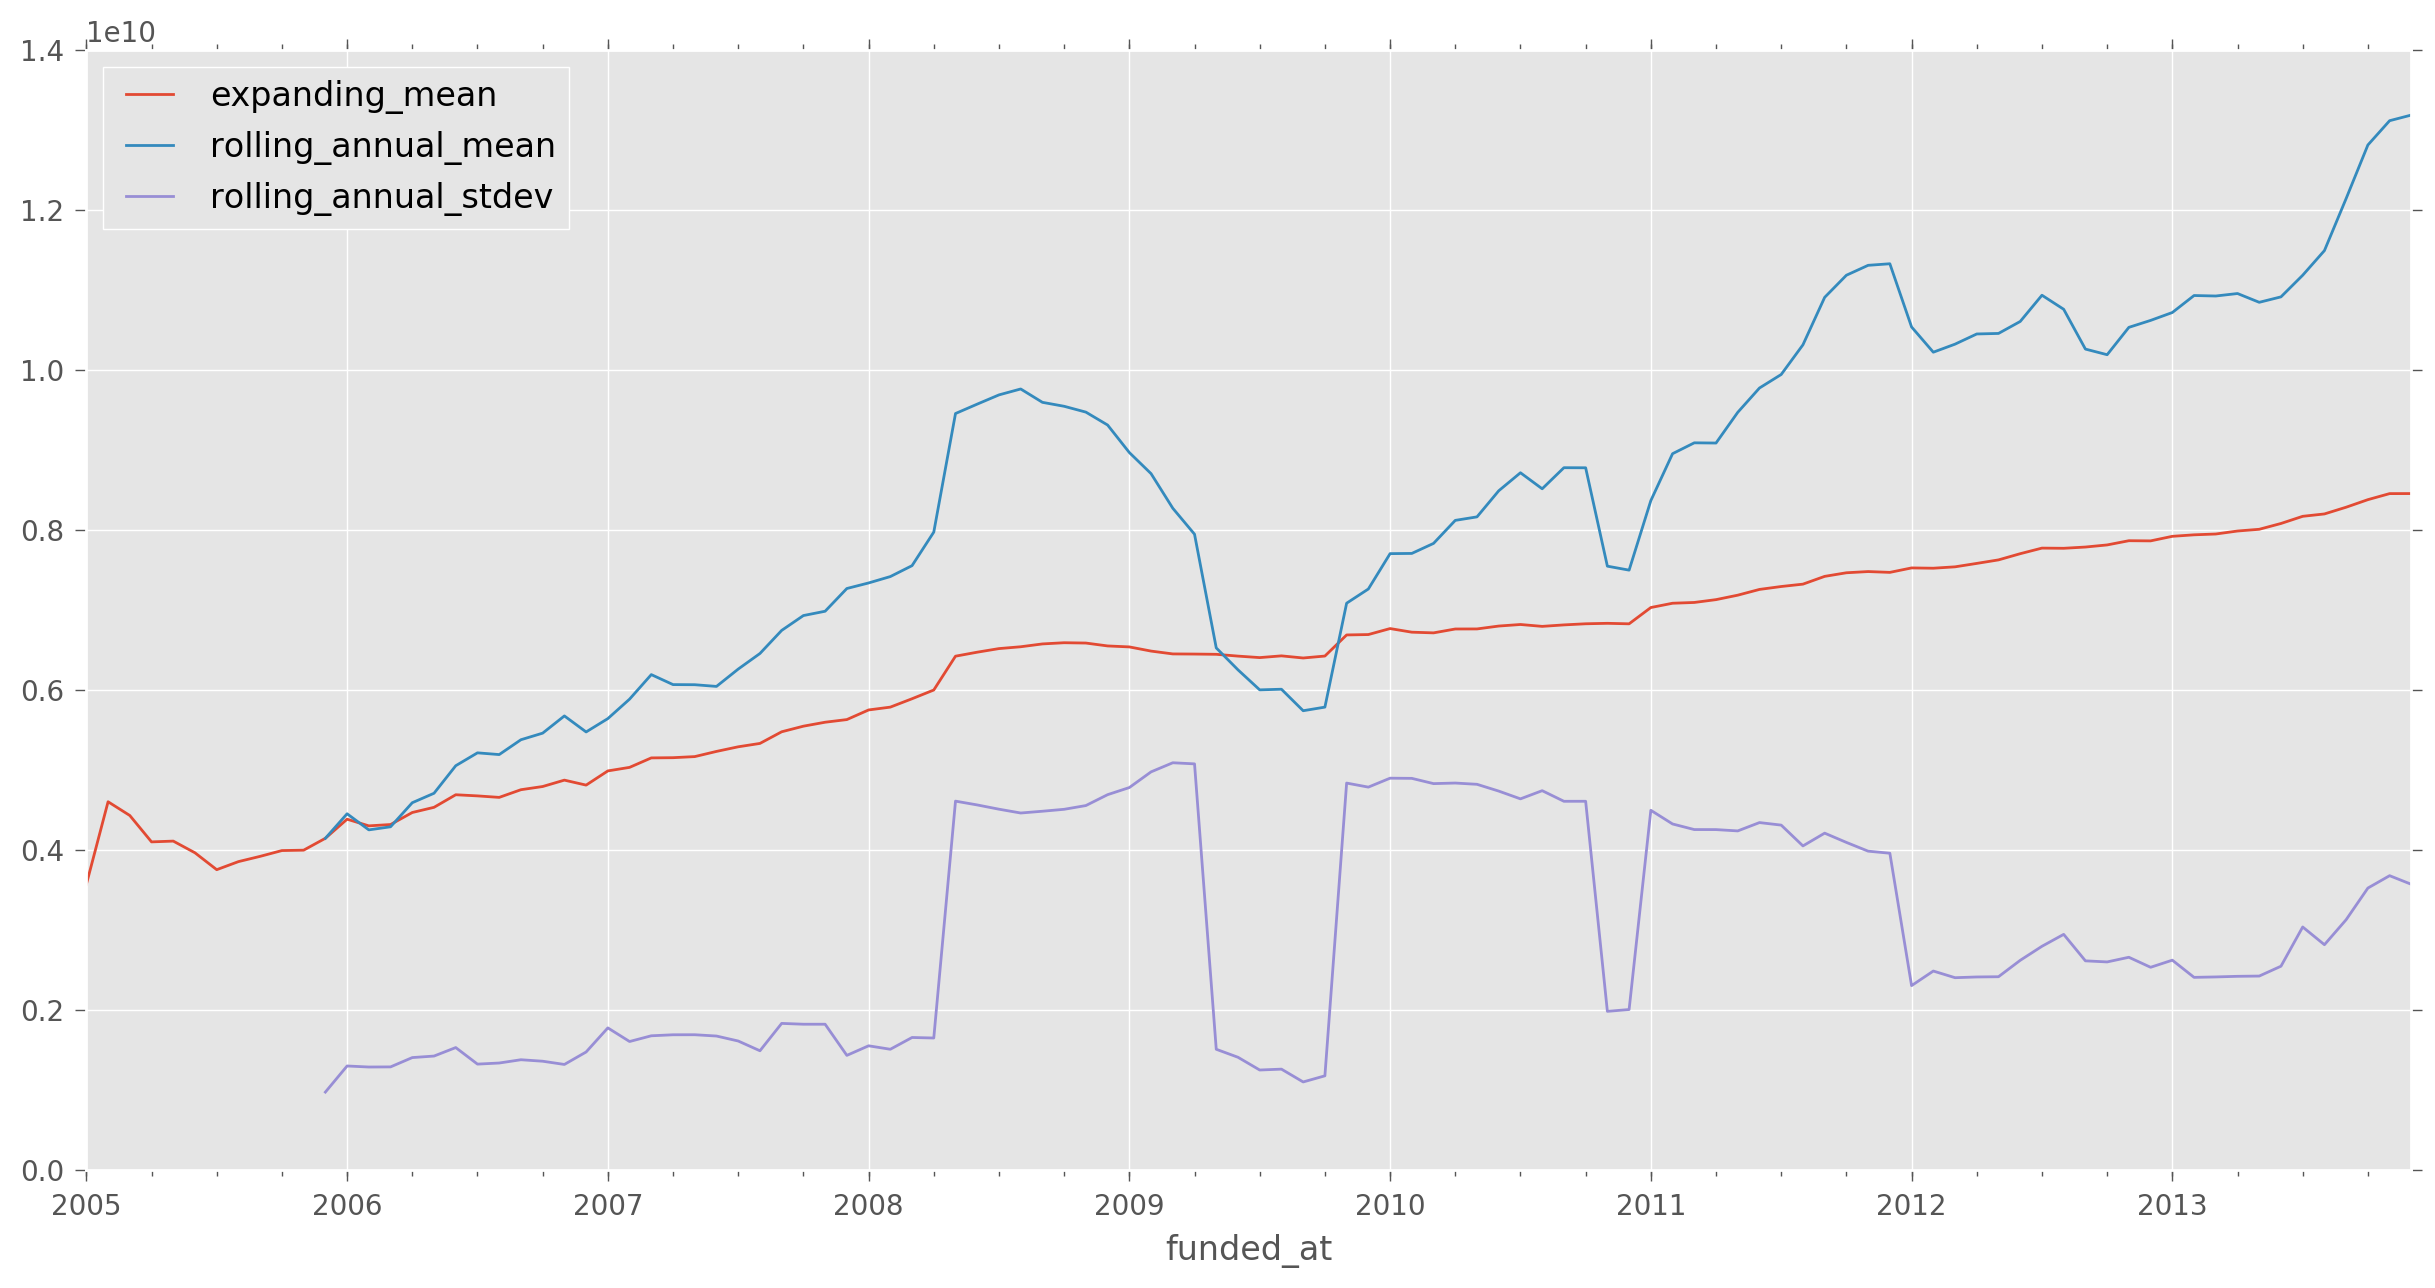

In [128]:
high_level.plot(x='funded_at', y=['expanding_mean', 'rolling_annual_mean', 'rolling_annual_stdev'], figsize=(15,7))

## Now let's break it down by sector given the same time period

In [2]:
sector_group = df_funding_timing.groupby(['funded_at', 'sector']).agg({'raised_amount_usd': 'sum'}).unstack().sort_index(1,1)
sector_group.columns = sector_group.columns.to_series().map('{0[1]}'.format)
time_line = sector_group.iloc[96:]

time_series = time_line.reset_index()

time_series['ticks'] = range(0,len(time_series.index.values))

time_series = time_series.apply(lambda x: x.fillna(value=0))

time_series['rolling_biotech'] = time_series.biotech.rolling(window=12).mean()
time_series['rolling_medical'] = time_series.medical.rolling(window=12).mean()
time_series['rolling_software'] = time_series.software.rolling(window=12).mean()
time_series['rolling_web'] = time_series.web.rolling(window=12).mean()
time_series['rolling_finance'] = time_series.finance.rolling(window=12).mean()
time_series['rolling_real_estate'] = time_series.real_estate.rolling(window=12).mean()
time_series['rolling_enterprise'] = time_series.enterprise.rolling(window=12).mean()
time_series['expanding_software'] = time_series.software.expanding().mean()
time_series['expanding_biotech'] = time_series.biotech.expanding().mean()

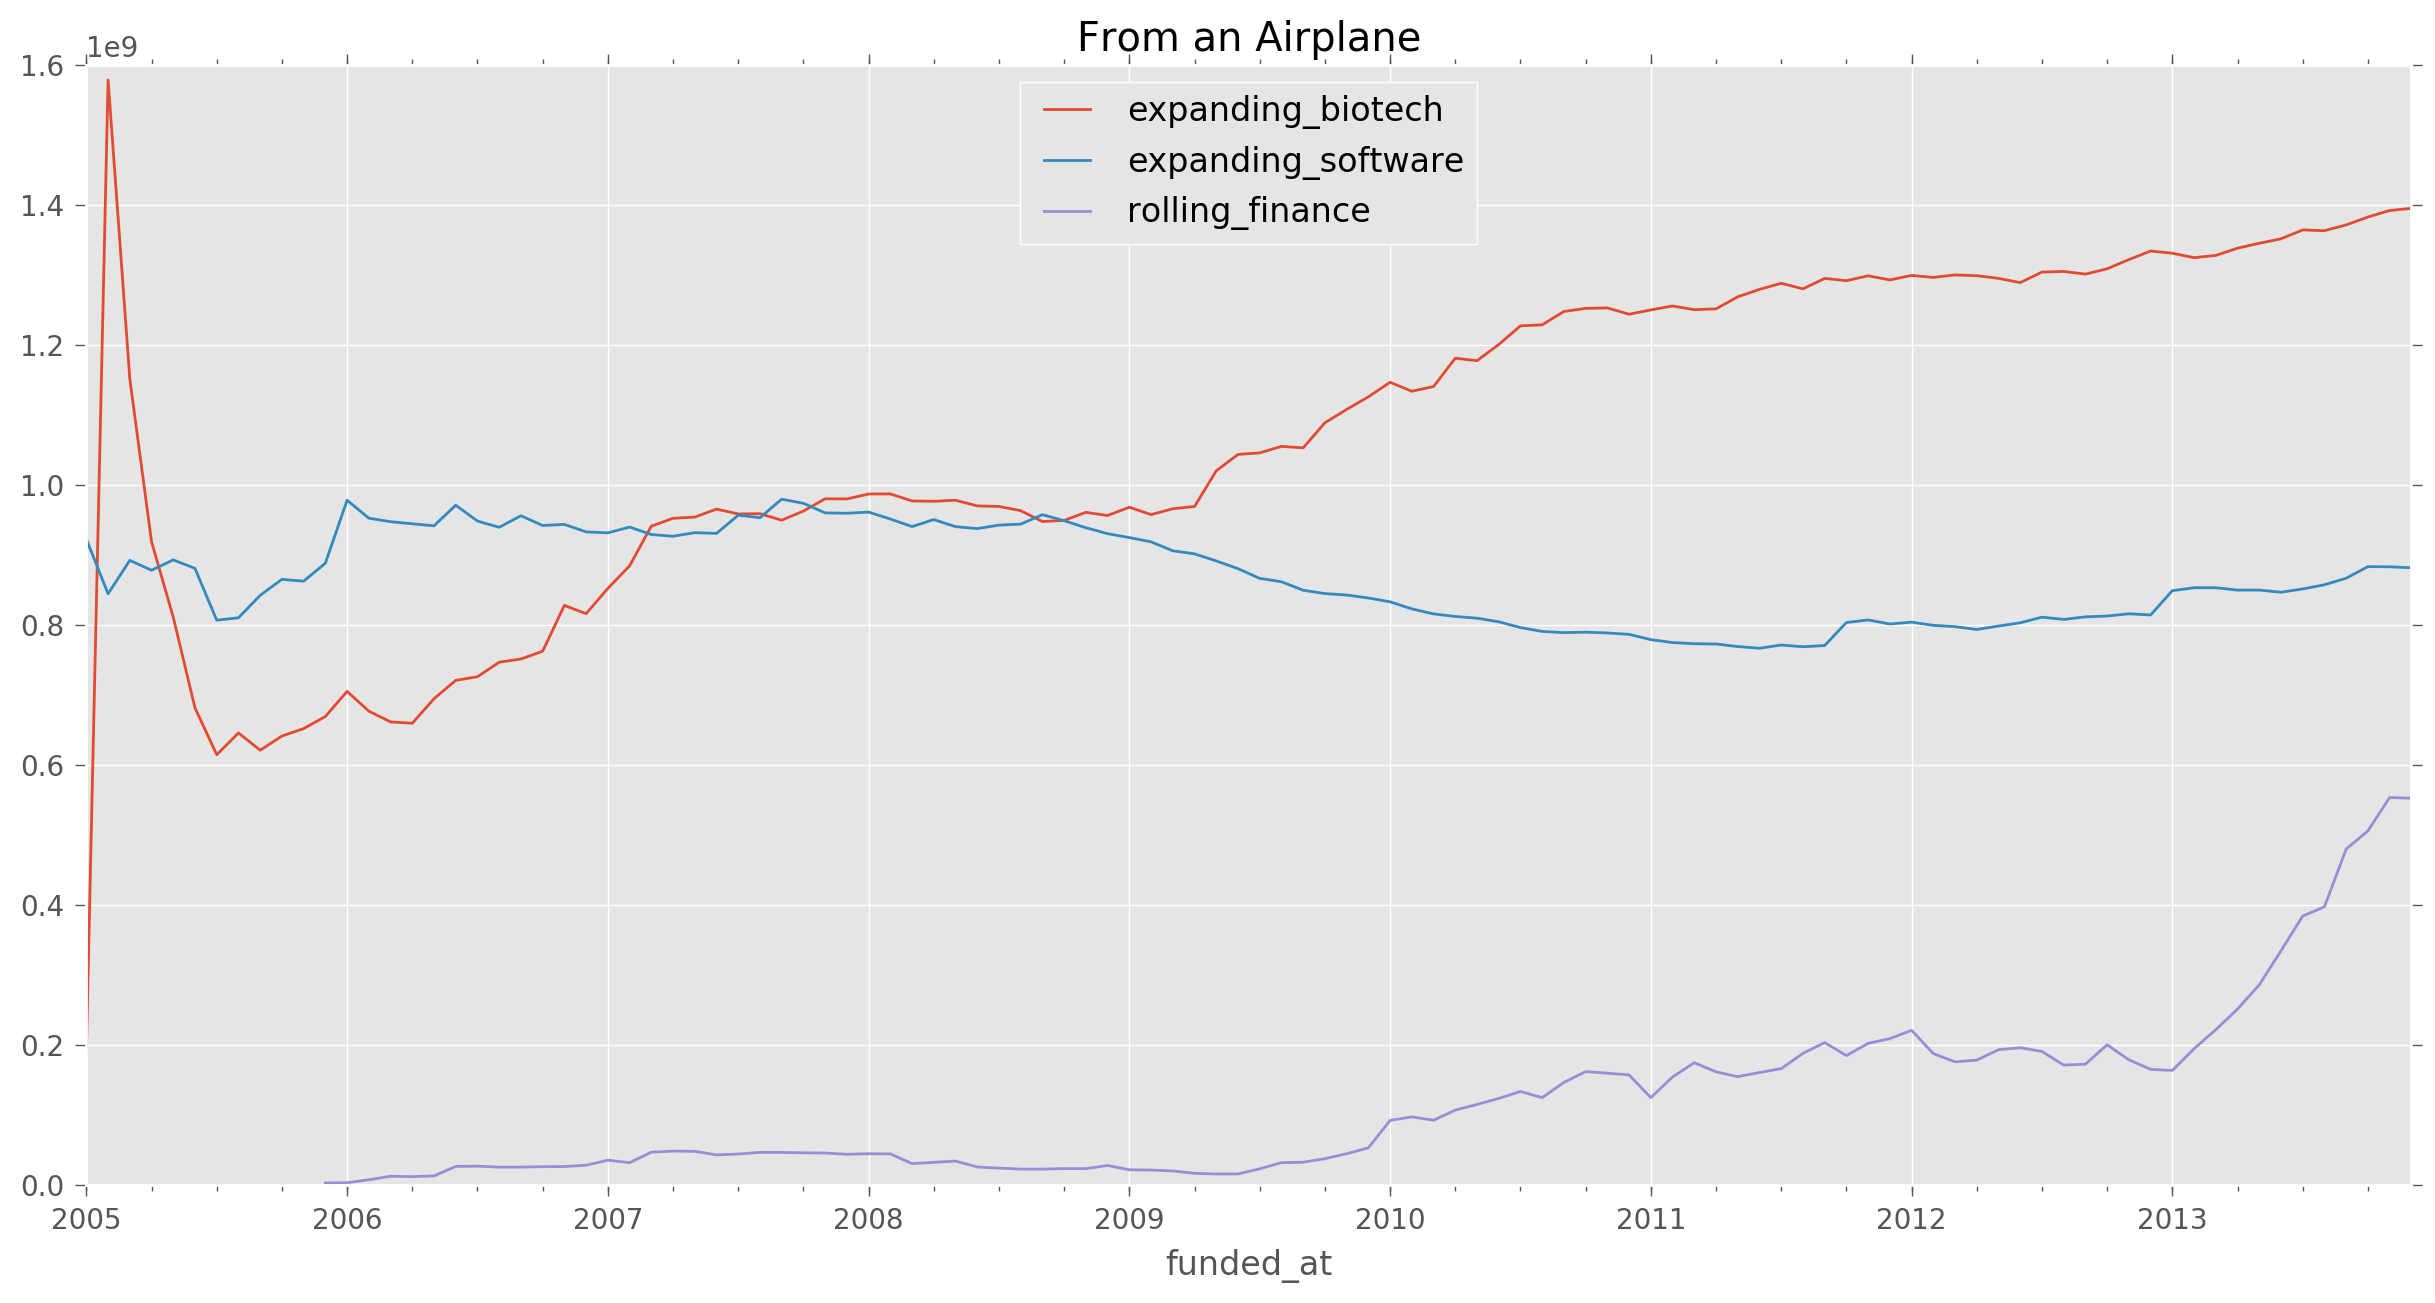

In [131]:
time_series.plot(x='funded_at', y=['expanding_biotech', 'expanding_software', 'rolling_finance'], figsize=(15,7), title='From an Airplane')
